# Evaluating a Classifier with FiftyOne

This notebook demonstrates an end-to-end example of fine-tuning a classification model [using fastai](https://github.com/fastai/fastai) on a [Kaggle dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) and using FiftyOne to evaluate it and understand the strengths and weaknesses of both the model and the underlying ground truth annotations.

Specifically, we'll cover:

- Downloading the dataset via the [Kaggle API](https://github.com/Kaggle/kaggle-api)
- Loading the dataset [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- Indexing the dataset by uniqueness using FiftyOne's [uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness) to identify interesting visual characteristics
- Fine-tuning a model on the dataset [using fastai](https://github.com/fastai/fastai)
- [Evaluating](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) the fine-tuned model using FiftyOne
- [Exporting](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html) the FiftyOne dataset for offline analysis

**So, what's the takeaway?**

The loss function of your model training loop alone doesn't give you the full picture of a model. In practice, the limiting factor on your model's performance is often data quality issues that FiftyOne can help you address. In this notebook, we'll cover:

- Viewing the *most unique* incorrect samples using FiftyOne's [uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness)
- Viewing the *hardest* incorrect predictions using FiftyOne's [hardness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness)
- Identifying ground truth *mistakes* using FiftyOne's [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes)

Running the workflow presented here on your ML projects will help you to understand the current failure modes (edge cases) of your model and how to fix them, including:

- Identifying scenarios that require additional training samples in order to boost your model's performance
- Deciding whether your ground truth annotations have errors/weaknesses that need to be corrected before any subsequent model training will be profitable

## Install FiftyOne

In [ ]:
#!pip install --upgrade fiftyone
!pip install fiftyone --no-binary fiftyone,voxel51-eta

In [ ]:
#!pip install opencv-python-headless==4.5.4.60

If you run into a `cv2` error when importing FiftyOne later on, it is an issue with OpenCV in Colab environments. [Follow these instructions to resolve it.](https://github.com/voxel51/fiftyone/issues/1494#issuecomment-1003148448)

## Download dataset

Let's start by downloading the [Malaria Cell Images Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) from Kaggle using the [Kaggle API](https://github.com/Kaggle/kaggle-api):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get my data and files
# Disney 3D Human Test
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_train_portraits.zip > /dev/null # val folder contains test images (disney_3D_human_test)
#!unzip /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/cropped_predictions_withBG_0.7threshold_labelled.zip > /dev/null # don't use the predictions with background (output from detection step) because there will be mismatches with the test set
#!unzip /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/cla_predictions_withBG_0.7threshold.zip > /dev/null # cla predictions including bg class (model 12)

# background and other are grouped under "background"
# non-humans with identifiable gender (e.g. Olaf, reindeer) have gender
# duplicates are counted even though they shouldn't be
#!unzip /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/disney_3D_human_test_resnet101inference_portraits.zip > /dev/null 

#!unzip /content/drive/MyDrive/machine_learning/datasets/2D_3D_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/Detection_Test_Inference_Portraits.zip > /dev/null # non-faces

# full film sanity check
!unzip /content/drive/MyDrive/machine_learning/Analysis/Films/mermaid.zip -d tlm > /dev/null
!unzip /content/drive/MyDrive/machine_learning/Analysis/Films/brave.zip -d brave > /dev/null

## Load dataset into FiftyOne

Let's load the dataset into [FiftyOne](https://voxel51.com/docs/fiftyone) and explore it!

### Create separate test dir (do if want even split of females and males)

In [ ]:
# import fiftyone as fo
# DATASET_DIR = "/content/test/all"

#"/content/disney_3D_human_test_resnet101inference_portraits" 
#"/content/disney_3D_human_train_portraits/val/human"

In [ ]:
# Optionally create a separate folder with the images to be tested
import os
import glob as gb
import shutil

DATASET_PATH = "2D_3D_portraits/*" #"disney_test_3D_portraits"
DST_PATH = "test"

for i in ['human', 'humanoid', 'animal', 'machine', 'all']:
  for j in ['male', 'female']:
    dir = f'{DST_PATH}/{i}/{j}'
    # delete folder contents if already exist
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)

for d in ["test"]:
  for char_style in ['human', 'humanoid', 'animal', 'machine']:
    females = [os.path.abspath(f) for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [os.path.abspath(f) for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/male/*.jpg"))]
    # females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{char_style}/female/*.jpg"))]
    # males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{char_style}/male/*.jpg"))]

    # Randomly shuffle all images and select equal number of faces
    import random
    random.seed(0)
    random.shuffle(females)
    random.shuffle(males)

    if len(females) < len(males):
      males_subset = random.sample(males, len(females))
      males = males_subset
    else:
      females_subset = random.sample(females, len(males))
      females = females_subset

    # Copy files into destination folders
    for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copyfile(full_fname, f"{DST_PATH}/{char_style}/{gender}/{fname}")
        shutil.copyfile(full_fname, f"{DST_PATH}/all/{gender}/{fname}") # all character styles together

In [ ]:
# Set path
data_dir = 'test'

# Gender distribution per character style
N = 0  # total files
gender_dist = {}
for dirpath, dirnames, filenames in os.walk(data_dir): 
    N_c = len(filenames)
    N += N_c
    # print("Files in ", dirpath, dirnames, N_c)

    if not dirnames: # list is empty so have full string and num files
      char_style = dirpath.split("/")[-2]
      label = dirpath.split("/")[-1]
      gender_dist[f"{char_style}_{label}"]= N_c

print("Total Files ", N)
print(gender_dist)

Total Files  5580
{'machine_male': 5, 'machine_female': 5, 'human_male': 699, 'human_female': 699, 'animal_male': 449, 'animal_female': 449, 'all_male': 1395, 'all_female': 1395, 'humanoid_male': 242, 'humanoid_female': 242}


In [ ]:
# get all unique filenames in test
onlyfiles = gb.glob(f"{data_dir}/all/*/*.jpg")
#onlyfilenames = list(map(lambda f: f.split("/")[-1], onlyfiles))
onlyfilenames = [f.split("/")[-1] for f in onlyfiles]
print(len(onlyfilenames))
print(onlyfilenames[0])

2790
home-on-the-range-disneyscreencaps.com-3393-2.jpg


In [ ]:
# Create gt-labels.json
import fiftyone as fo
import json

portraits_list = []
json_file = "2D_3D_portraits/portraits_new.json"

# Read .json
with open(f"{json_file}") as f:
    portraits_list.extend(json.load(f))
print(f"Total length: {len(portraits_list)}")

samples = []
new_portraits_list = []
# Change path name
for portrait in portraits_list:
  path = portrait["path"]
  _, _, _, ani, dset, char, gender, fname = path.split("\\")
  # print(ani, dset, char, gender, fname)
  if dset == "test" and gender != "other":
    if fname in onlyfilenames:
      new_path = f"{DST_PATH}/all/{gender}/{fname}"
      portrait["path"] = new_path
      new_portraits_list.append(portrait)

      # Store classification for 51 dataset
      sample = fo.Sample(filepath=new_path)
      label = portrait["gender"]
      sample["bbox"] = portrait["bbox"]
      sample["bbox_area"] = portrait["area"]
      sample["animation_style"] = portrait["animation_style"]
      sample["character_style"] = portrait["character_style"]
      sample["ground_truth"] = fo.Classification(label=label)
      samples.append(sample)
  
print(f"Total length portrait_list: {len(new_portraits_list)}, Total length samples: {len(samples)}")

# Save to file
jsonString = json.dumps(new_portraits_list)
jsonFile = open(f"gt-labels.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

# Create dataset
dataset = fo.Dataset("classification-test-set")
dataset.add_samples(samples)

In [ ]:
# Visualize the GT annotations
dataset.first()

### Create FiftyOne dataset

FiftyOne provides builtin support for loading datasets in [dozens of common formats](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) with a single line of code:

In [ ]:
# Create FiftyOne dataset
import glob
import fiftyone as fo
import json

DATASET_DIR = "/content/2D_3D_portraits"

# Read .json
portraits_list = []
json_file = "portraits_new.json"
with open(f"{DATASET_DIR}/{json_file}") as f:
    portraits_list.extend(json.load(f))
print(f"Total # portraits: {len(portraits_list)}")

# Create samples for your data
samples = []
for portrait in portraits_list:
  path = portrait["path"]
  _, _, _, ani, dset, char, gender, fname = path.split("\\")
  new_path = f"{DATASET_DIR}/{ani}/{dset}/{char}/{gender}/{fname}"
  portrait["path"] = new_path
  
  if dset == "test" and gender != "other":
    # Store classification
    sample = fo.Sample(filepath=new_path)
    label = portrait["gender"]
    sample["bbox"] = portrait["bbox"]
    sample["bbox_area"] = portrait["area"]
    sample["animation_style"] = portrait["animation_style"]
    sample["character_style"] = portrait["character_style"]
    sample["ground_truth"] = fo.Classification(label=label)
    samples.append(sample)

# Create dataset
dataset = fo.Dataset("classification-test")
dataset.add_samples(samples)

In [ ]:
# Create FiftyOne dataset to test classification of MISDETECTIONS
# Uses folder structure, no .json file to upload gt

import fiftyone as fo

DATASET_DIR = "/content/test"

dataset = fo.Dataset.from_dir(
    DATASET_DIR,
    fo.types.ImageClassificationDirectoryTree,
    name="test",
)
dataset.persistent = True

print(dataset)

Migrating database to v0.16.6


INFO:fiftyone.migrations.runner:Migrating database to v0.16.6


 100% |█████████████| 17728/17728 [11.5s elapsed, 0s remaining, 1.5K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 17728/17728 [11.5s elapsed, 0s remaining, 1.5K samples/s]      


Name:        test
Media type:  image
Num samples: 17728
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [ ]:
# Visualize the GT annotations
dataset.first()

<Sample: {
    'id': '6318e90aea25a8a0064ee95c',
    'media_type': 'image',
    'filepath': '/content/test/female/101-dalmatians-disneyscreencaps.com-1845-183.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '6318e90aea25a8a0064ee95b',
        'tags': BaseList([]),
        'label': 'female',
        'confidence': None,
        'logits': None,
    }>,
}>

### (Future use) Load an existing FiftyOne dataset

Now that the data is loaded into FiftyOne, you can easily [work with](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html) the same dataset in a future session on the same machine by loading it by name:

In [ ]:
# Load existing dataset
dataset = fo.load_dataset("disney_3D_human_test_resnet101")
print(dataset)

Name:        disney_3D_human_test_resnet101
Media type:  image
Num samples: 791
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


### Index the dataset by visual uniqueness

Let's start by indexing the dataset by visual uniqueness using FiftyOne's [image uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness).

This method adds a scalar `uniqueness` field to each sample that measures the relative visual uniqueness of each sample compared to the other samples in the dataset.

In [ ]:
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

INFO:fiftyone.core.models:Downloading model from Google Drive ID '1SIO9XreK0w1ja4EuhBWcR10CnWxCOsom'...


 100% |████|  100.6Mb/100.6Mb [138.2ms elapsed, 0s remaining, 727.7Mb/s]      


INFO:eta.core.utils: 100% |████|  100.6Mb/100.6Mb [138.2ms elapsed, 0s remaining, 727.7Mb/s]      


Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |█████████████| 17728/17728 [3.1m elapsed, 0s remaining, 100.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 17728/17728 [3.1m elapsed, 0s remaining, 100.8 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Computing neighbors for 17728 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.uniqueness:Computing neighbors for 17728 embeddings; this may take awhile...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


### Visualize dataset in the App

Now let's launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and use it to interactively explore the dataset.

For example, try using the [view bar](https://voxel51.com/docs/fiftyone/user_guide/app.html#using-the-view-bar) to sort the samples so that we can view the *most visually unique* samples in the dataset:

In [ ]:
# Most of the MOST UNIQUE samples are parasitized
# session = fo.launch_app(dataset)

# How to try to prevent the views from reloading constantly 
# when multiple are rendered for the same session: https://voxel51.com/docs/fiftyone/environments/index.html#notebooks
session = fo.launch_app(dataset, auto=False)
session.show()

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


KeyboardInterrupt: ignored

In [ ]:
# # Export dataset in JSON format (no images)
# JSON_PATH = "gt-labels.json"

# dataset.write_json(JSON_PATH, rel_dir=DATASET_DIR)

Now let's add a `Limit(500)` stage in the view bar and open the `Labels` tab to view some statistics about the 500 most unique samples in the dataset.

Notice that a vast majority of the most visually unique samples in the dataset are `Parasitized`, which makes sense because these are the infected, abnormal cells.

Conversely, if we use the view bar to show the 500 *least visually unique* samples, we find that 499 of them are `Uninfected`!

## Look at data

In [ ]:
!pip install --upgrade fastai

In [ ]:
import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

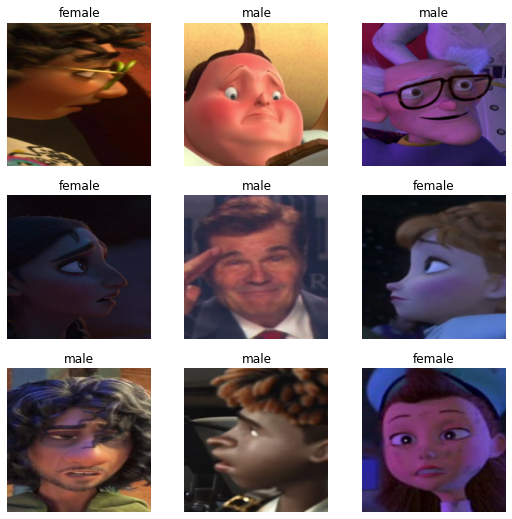

In [ ]:
# Load dataset into fastai

path = Path(f"{DATASET_DIR}/3D/test/human")

splitter = RandomSplitter(valid_pct=0.2)

# https://asvcode.github.io/Blogs/fastai/augmentation/image-augmentation/2020/03/26/Fastai2-Image-Augmentation.html
# https://forums.fast.ai/t/resize-instead-of-crop/28680/9
item_tfms = [Resize(224, method=ResizeMethod.Squish)]
batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    #splitter=splitter,
    item_tfms=item_tfms,
    #batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

## Evaluating model with FiftyOne

While 96% accuracy sounds great, aggregate evaluation metrics are not enough to get a full understanding of the performance of a model and what needs to be done to further improve it.

### Add predictions to FiftyOne dataset

Let's [add our model's predictions](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels) to our FiftyOne dataset so we can evaluate it in more detail:

In [ ]:
import torch
import torch.nn as nn
import sys
import numpy as np
import torchvision
from torch.utils.data import DataLoader
import fiftyone.utils.torch as fout

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Load model
from torchvision import models
# model_name = 'RES18_FeatureExtractor_FineTuned_Disney_Checkpoint12_model.pth'
# path_to_model = f'/content/drive/MyDrive/machine_learning/Code/Face_Gender_Classifier/{model_name}'
# model = models.resnet50(pretrained=True) # resnet18 or resnet50
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 3, bias=False) # binary classification: len(class_names) == 2, 3 if with background #, bias=False
# model.load_state_dict(torch.load(path_to_model, map_location=device))
# model.to(device)
# model.eval()

!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/003_new.zip > /dev/null

model_name = 'model_best.pt' 
path_to_model = f'/content/output/{model_name}' 
model = torch.load(path_to_model, map_location=device)
model.to(device)
model.eval()

In [ ]:
#https://voxel51.com/docs/fiftyone/recipes/adding_classifications.html

def make_imagenet_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences

#
# Extract a few images to process
#

batch_size = 64
image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in dataset])
data_loader = make_imagenet_data_loader(image_paths, sample_ids, batch_size)

In [ ]:
classes = ["female","male"] #"background"

In [ ]:
#
# Perform prediction and store results in dataset
#

with fo.ProgressBar() as pb:
    for imgs, sample_ids in pb(data_loader):
        predictions, confidences = predict(model, imgs)

        # Add predictions to your FiftyOne dataset
        for sample_id, prediction, confidence in zip(
            sample_ids, predictions, confidences
        ):
            sample = dataset[sample_id]
            sample["predictions"] = fo.Classification(
                label=classes[prediction],
                confidence=confidence,
            )
            sample.save()

 100% |█████████████████████| 3/3 [49.9s elapsed, 0s remaining, 0.1 samples/s]    


INFO:eta.core.utils: 100% |█████████████████████| 3/3 [49.9s elapsed, 0s remaining, 0.1 samples/s]    


In [ ]:
print(dataset)

Name:        test
Media type:  image
Num samples: 190
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [ ]:
# Sort predictions by confidence
pred_view = (dataset.exists("predictions").sort_by("predictions.confidence", reverse=True))

print("Number of samples with predictions: %s\n" % len(pred_view))
print("Highest confidence prediction:\n")
print(pred_view.first())

Number of samples with predictions: 190

Highest confidence prediction:

<SampleView: {
    'id': '6318e90aea25a8a0064eea5c',
    'media_type': 'image',
    'filepath': '/content/test/female/frozen-disneyscreencaps.com-1713-761.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '6318e90aea25a8a0064eea1c',
        'tags': BaseList([]),
        'label': 'female',
        'confidence': None,
        'logits': None,
    }>,
    'uniqueness': 0.3355440445239123,
    'predictions': <Classification: {
        'id': '6318ea4bea25a8a0064eed9a',
        'tags': BaseList([]),
        'label': 'female',
        'confidence': 0.9999464154243469,
        'logits': None,
    }>,
}>


In [ ]:
session.show()

In [ ]:
from fiftyone import ViewField as F

# Create different views
# pred_view is conf 50
conf_view_60 = dataset.filter_labels("predictions", F("confidence") >= 0.60)
conf_view_70 = dataset.filter_labels("predictions", F("confidence") >= 0.70)
conf_view_80 = dataset.filter_labels("predictions", F("confidence") >= 0.80)
conf_view_90 = dataset.filter_labels("predictions", F("confidence") >= 0.90)

s_view = dataset.match(F("bbox_area") < 32 ** 2)
m_view = dataset.match((F("bbox_area") >= 32 ** 2) & (F("bbox_area") >= 96 ** 2))
l_view = dataset.match(F("bbox_area") >= 96 ** 2)

d2_view = dataset.match(F("animation_style") == "2_d")
d3_view = dataset.match(F("animation_style") == "3_d")

human_view = dataset.match(F("character_style") == "human")
humanoid_view = dataset.match(F("character_style") == "humanoid")
animal_view = dataset.match(F("character_style") == "animal")
machine_view = dataset.match(F("character_style") == "machine")

In [ ]:
# Load high confidence view in the App
session.view = s_view
session.show()

### Running the evaluation

FiftyOne provides a powerful [evaluation API](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) for evaluating various types of models at the aggregate and sample-level.

In this case, we'll use the [binary classification functionality](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#binary-evaluation) to analyze our model:

In [ ]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary", # defaults to 'simple', use 'binary' if binary classifier bc can then plot pr cruve
    classes=classes, #classes
)

In [ ]:
# sources: 
# https://voxel51.com/docs/fiftyone/user_guide/evaluation.html
# https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.classification.html#fiftyone.utils.eval.classification.ClassificationResults

conf_results_60 = conf_view_60.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_60_conf", method="binary", classes=classes)
conf_results_70 = conf_view_70.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_70_conf", method="binary", classes=classes)
conf_results_80 = conf_view_80.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_80_conf", method="binary", classes=classes)
conf_results_90 = conf_view_90.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_90_conf", method="binary", classes=classes)

s_results = s_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_s", method="binary", classes=classes)
m_results = m_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_m", method="binary", classes=classes)
l_results = l_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_l", method="binary", classes=classes)

d2_results = d2_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_d2", method="binary", classes=classes)
d3_results = d3_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_d3", method="binary", classes=classes)

human_results = human_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_human", method="binary", classes=classes)
humanoid_results = humanoid_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_humanoid", method="binary", classes=classes)
animal_results = animal_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_animal", method="binary", classes=classes)
machine_results = machine_view.evaluate_classifications("predictions", gt_field="ground_truth", eval_key="eval_machine", method="binary", classes=classes)

The method returned a `results` object that provides a number of convenient methods for analyzing our predictions.

### Viewing aggregate metrics

Let's start by printing a classification report:

In [ ]:
print(f"Results:")
results.print_report()
print(f"60 Conf Results:")
conf_results_60.print_report()
print(f"70 Conf Results:")
conf_results_70.print_report()
print(f"80 Conf Results:")
conf_results_80.print_report()
print(f"90 Conf Results:")
conf_results_90.print_report()

print(f"Small Bbox Results:")
s_results.print_report()
print(f"Medium Bbox Results:")
m_results.print_report()
print(f"Large Bbox Results:")
l_results.print_report()

print(f"2D Results:")
d2_results.print_report()
print(f"3D Results:")
d3_results.print_report()

print(f"Human Results:")
human_results.print_report()
print(f"Humanoid Results:")
humanoid_results.print_report()
print(f"Animal Results:")
animal_results.print_report()
print(f"Machine Results:")
machine_results.print_report()

Results:
              precision    recall  f1-score   support

      female       0.80      0.71      0.75      1395
        male       0.74      0.82      0.78      1395

    accuracy                           0.77      2790
   macro avg       0.77      0.77      0.77      2790
weighted avg       0.77      0.77      0.77      2790

60 Conf Results:
              precision    recall  f1-score   support

      female       0.81      0.72      0.77      1318
        male       0.75      0.84      0.79      1329

    accuracy                           0.78      2647
   macro avg       0.78      0.78      0.78      2647
weighted avg       0.78      0.78      0.78      2647

70 Conf Results:
              precision    recall  f1-score   support

      female       0.83      0.73      0.78      1216
        male       0.77      0.86      0.81      1257

    accuracy                           0.79      2473
   macro avg       0.80      0.79      0.79      2473
weighted avg       0.80      0.

Now, how about a confusion matrix:

In [ ]:
plot = results.plot_confusion_matrix()
#plot = conf_results_70.plot_confusion_matrix()

#plot = s_results.plot_confusion_matrix()
#plot = m_results.plot_confusion_matrix()
#plot = l_results.plot_confusion_matrix()

#plot = d2_results.plot_confusion_matrix()
#plot = d3_results.plot_confusion_matrix()

#plot = human_results.plot_confusion_matrix()
#plot = humanoid_results.plot_confusion_matrix()
#plot = animal_results.plot_confusion_matrix()
#plot = machine_results.plot_confusion_matrix()

plot.show()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1783: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



In [ ]:
plot.freeze()  # replaces interactive plot with static image

and finally a precision-recall curve:

In [ ]:
plot = results.plot_pr_curve()
# plot = high_conf_results.plot_pr_curve()

# plot = s_results.plot_pr_curve()
# plot = m_results.plot_pr_curve()
# plot = l_results.plot_pr_curve()

# plot = d2_results.plot_pr_curve()
# plot = d3_results.plot_pr_curve()

# plot = human_results.plot_pr_curve()
# plot.data[0].line.color = "red"
# plot = humanoid_results.plot_pr_curve(figure=plot)
# plot.data[1].line.color = "blue"
# plot = animal_results.plot_pr_curve(figure=plot)
# plot.data[1].line.color = "green"
# plot = machine_results.plot_pr_curve(figure=plot)
# plot.data[1].line.color = "orange"
# plot.update_layout(showlegend=True)

plot.show()

In [ ]:
plot.freeze()  # replaces interactive plot with static image

The evaluation method also populated a new `eval` field on our samples that records whether each prediction is a true positive (TP), false positive (FP), false negative (FN), or true negative (TN).

In a few minutes, we'll use this field to interactively explore each type of prediction visually in the App. But for now, let's check the distribution of these labels:

In [ ]:
print(dataset.count_values("eval"))
# males predicted as females, correct females, females predicted as males, correct males

{'FN': 250, 'TN': 992, 'FP': 403, 'TP': 1145}


### Visualizing the most unique predictions

Now that we have a sense for the aggregate performance of our model, let's dive into sample-level analysis by loading a [dataset view](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) in the App that shows the correctly predicted samples from the validation split, sorted in descending order by the visual uniqueness that we previously computed and stored in the `uniqueness` field of the dataset:

In [ ]:
# Show most unique CORRECT predictions on validation split
session.view = (
    dataset
    .match(F("predictions.label") == F("ground_truth.label"))
    .sort_by("uniqueness", reverse=True)
)
session.show()

Now, things get more interesting when we update our view to show the most visually unique **INCORRECT** predictions from the validation split.

Note that some of these ground truth labels look questionable; it seems that some of our our ground truth annotations may need to be updated. We'll investigate this more later.

In [ ]:
# Show most unique INCORRECT predictions on validation split
session.view = (
    dataset
    .match(F("predictions.label") != F("ground_truth.label"))
    .sort_by("uniqueness", reverse=True)
)
session.show()

### Compute sample hardness with FiftyOne (need to store logits for this)

During training, it is useful to identify samples that are more difficult for a model to learn so that training can be more focused around these hard samples.

Let's use FiftyOne's [hardness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness) to index our dataset by the hardness of our predictions in the `predictions` field.

This method populates a scalar `hardness` field on each of our samples.

In [ ]:
import fiftyone.brain as fob

fob.compute_hardness(dataset, "predictions")

Now let's use our hardness measure to view the **HARDEST FALSE POSITIVE** samples in the validation split of our dataset.

These are the failure modes of our current model, and this is where we need to dedicate our human time to understand what's going on.

Here are some important questions to ask yourself:

- *Are any of the ground truth annotations on these samples incorrect?* If so, then correcting them will make the biggest positive impact on the ability of our model to separate these two classes
- *Are these predictions actually false positives?* If so, then adding more examples that are visually similar to these to your training dataset will also improve your model


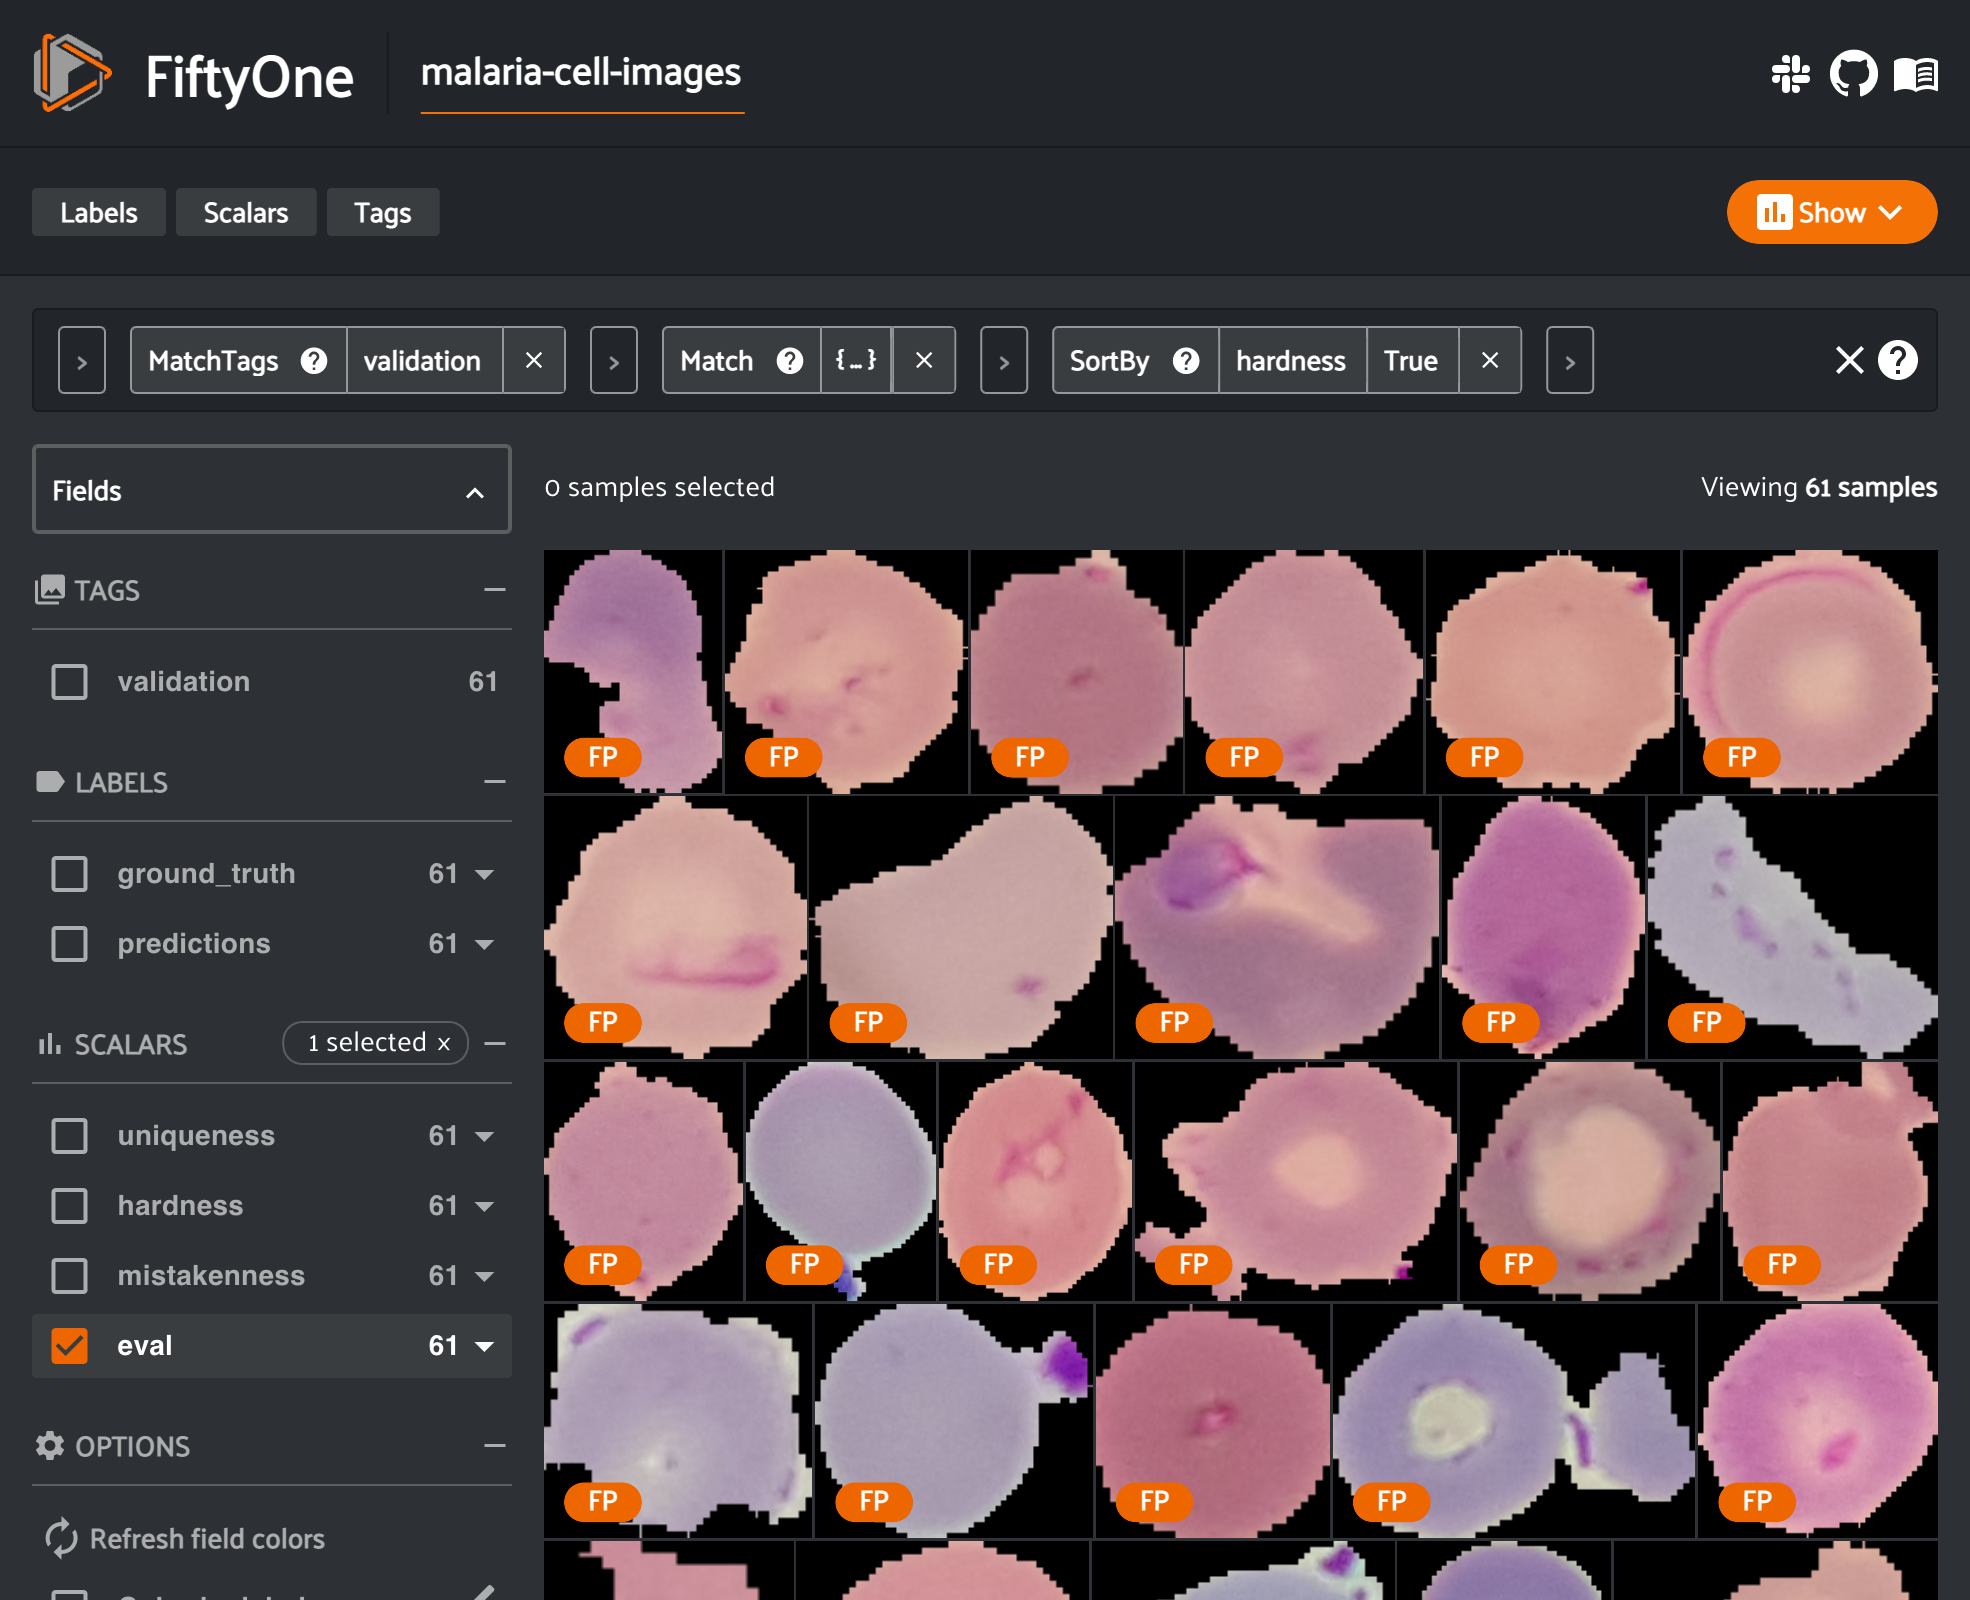

In [ ]:
# Show the HARDEST FALSE POSITIVES on validation split
session.view = (
    dataset
    .match(F("eval") == "FP")
    .sort_by("hardness", reverse=True)
)

Viewing the **HARDEST FALSE NEGATIVE** samples from the validation split also gives insights into what fools our model into wrongly believing that a sample is uninfected.

Or, are the ground truth annotations incorrect? The same questions from the previous section apply. Finding mistakes in your ground truth data is equally as important as identifying the true failure modes of your model.


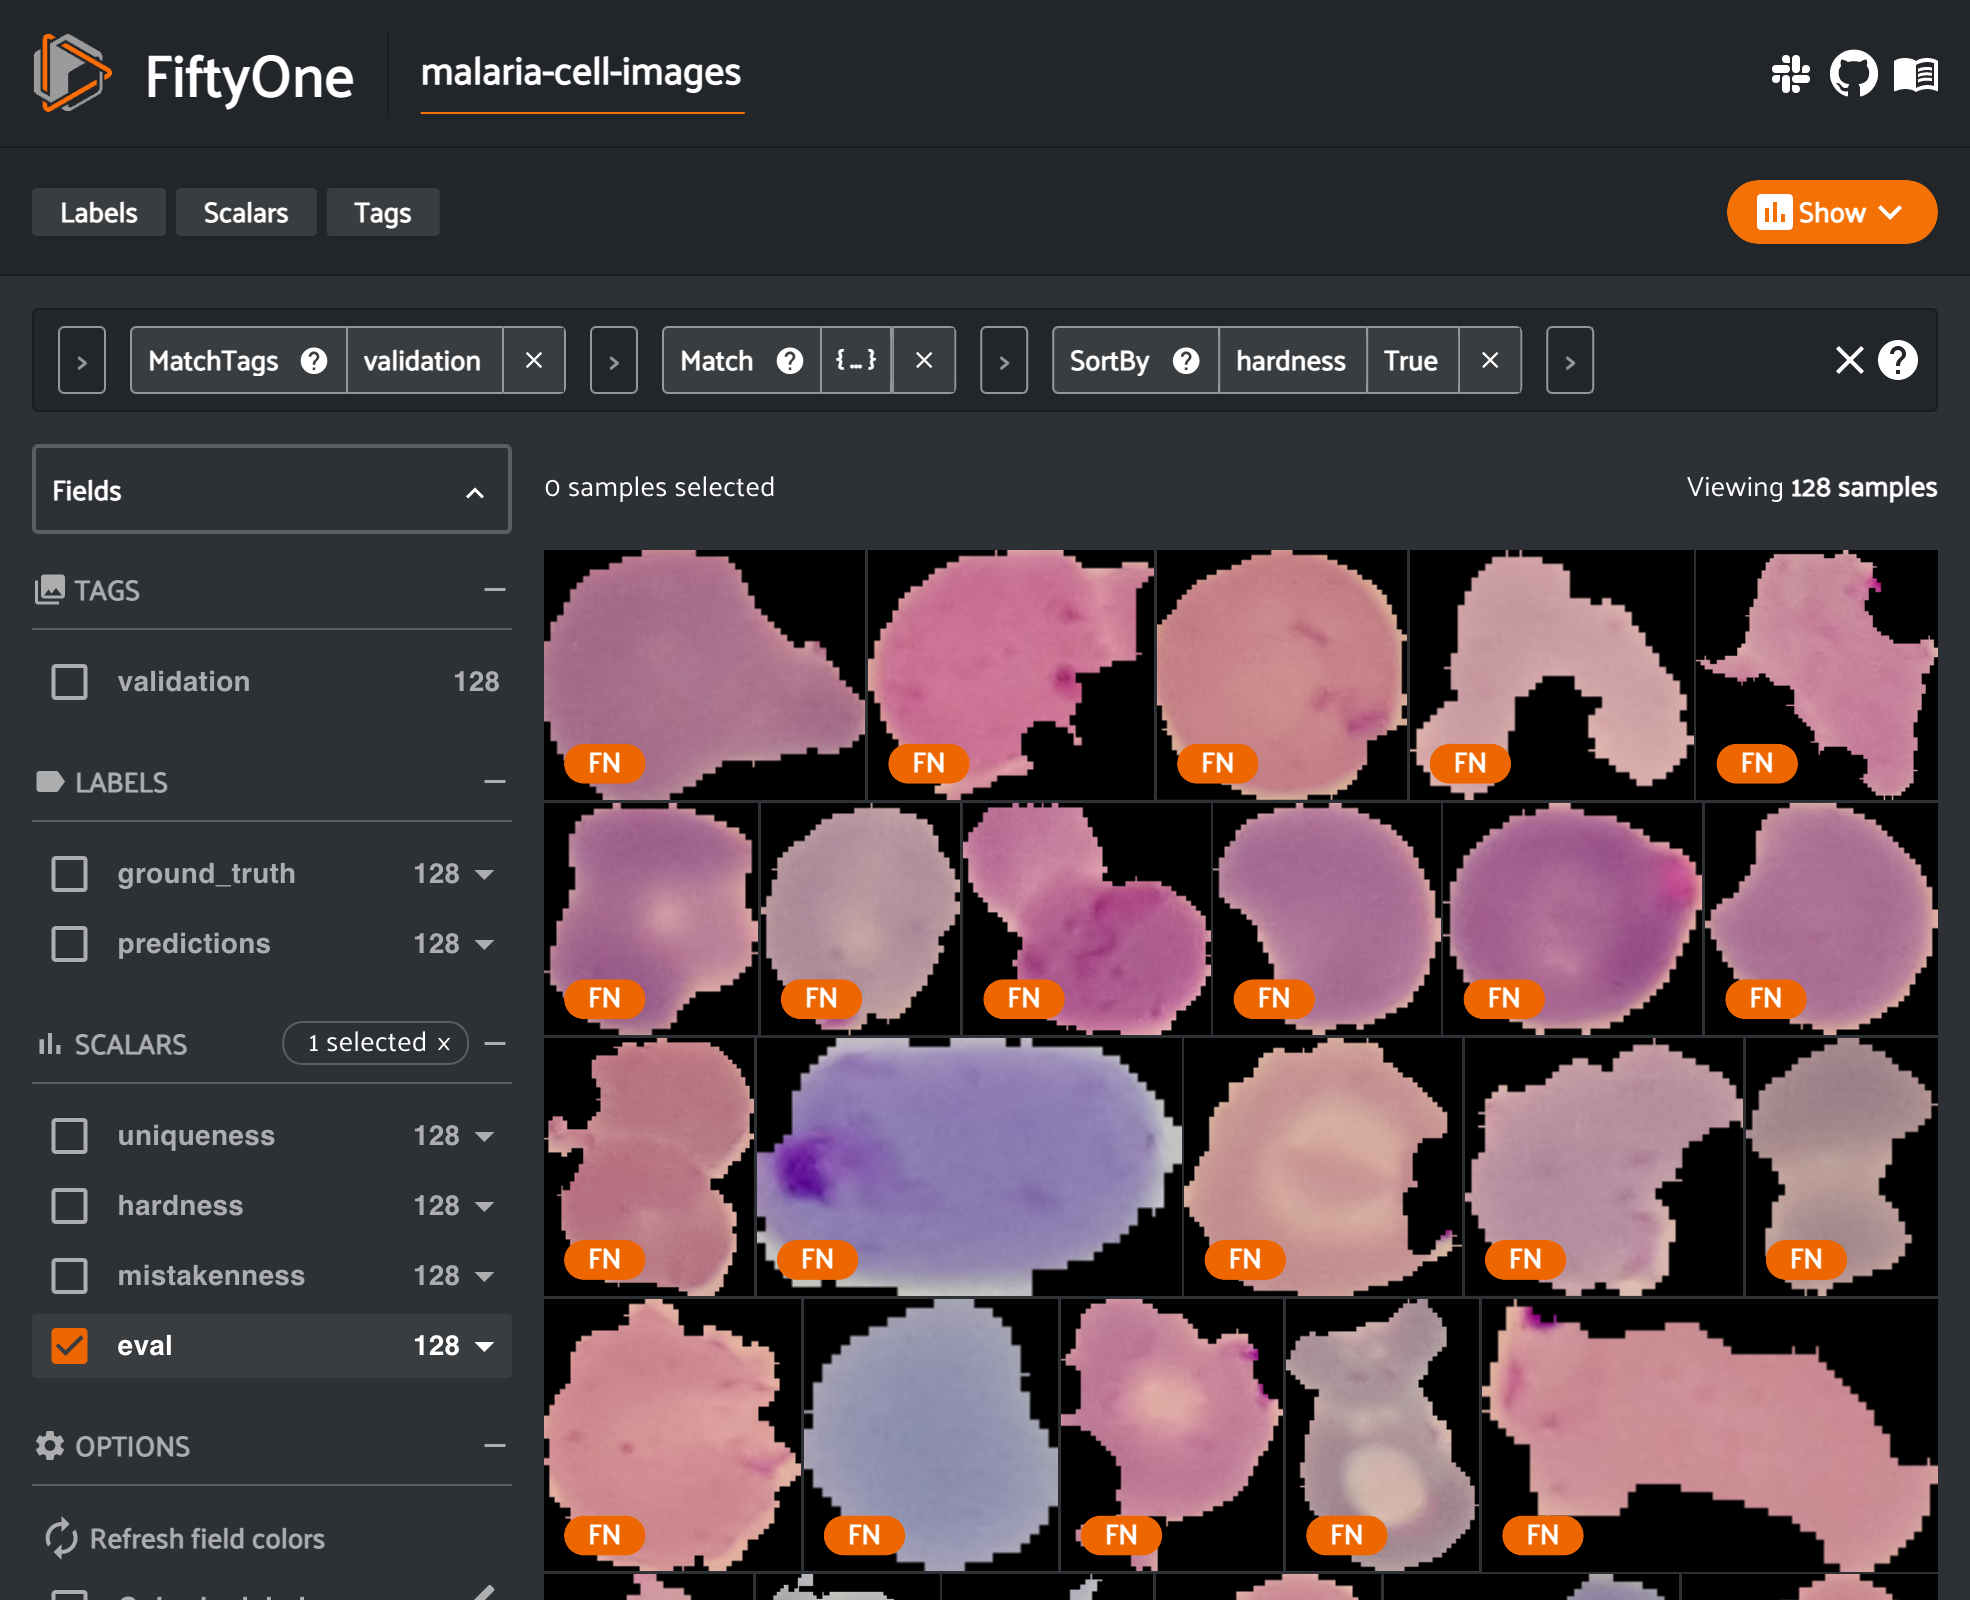

In [ ]:
# Show the HARDEST FALSE NEGATIVES on validation split
session.view = (
    dataset
    .match_tags("validation")
    .match(F("eval") == "FN")
    .sort_by("hardness", reverse=True)
)

### Finding ground truth mistakes using FiftyOne

Even well-known datasets can have [significant ground truth mistakes](https://towardsdatascience.com/i-performed-error-analysis-on-open-images-and-now-i-have-trust-issues-89080e03ba09).

Fortunately, FiftyOne provides a [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes) that can automatically identify the potential ground truth mistakes in your dataset.

The cell below runs the mistakenness method using the predictions in the `predictions` field of the dataset as a point of reference to find the most likely mistakes in the `ground_truth` annotations: 

In [ ]:
import fiftyone.brain as fob

fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |███████████████| 2790/2790 [6.7s elapsed, 0s remaining, 383.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 2790/2790 [6.7s elapsed, 0s remaining, 383.5 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


We can easily update our view in the App to show, for example, the most likely annotation mistakes in the `train` split of our dataset. In the cell below, we have only selected the `eval` field in the App so that we see the samples together with their TP/FP/FN/TN evaluation labels.

I'm not a medical imaging expert, but to my untrained eye, the examples below suggest two concrete opportunities for improvement to our training dataset:

- Many of the false negatives below seem to be *true negatives*. These ground truth annotations likely need another annotation pass to correct for errors
- Many of the remaining false negatives seem to be cases where the infection is near the **boundary** of the cell images. Augmenting the training dataset with more `Parasitized` examples of this kind would likely improve the performance of our model!

In [ ]:
# Show the most likely ANNOTATION MISTAKES on the train split
session.view = (
    dataset
    #.match_tags("train")
    .sort_by("mistakenness", reverse=True)
)

In [ ]:
session.freeze()

## Export incorrect samples for further analysis

Now that we've identified some potential sources of annotation error, we can easily extract some aggregate analyses of the incorrect predictions:

In [ ]:
# Print stats about errors
fp = dataset.match(F("eval") == "FP")
fn = dataset.match(F("eval") == "FN")

print("FP: %d" % fp.count())
print("FN: %d" % fn.count())

# females predicted as males are labelled FP
# males predicted as females are labelled FN

FP: 403
FN: 250


In [ ]:
errors_view = dataset.match(F("eval").is_in(["FP", "FN"]))
session.view = errors_view
session.show()

The code sample below generates a JSON export of the 1042 samples in the dataset where the model generated false positive or false negative predictions:

This JSON file includes the filepaths for the raw images, so this file can be easily forwarded to your annotation team/vendor to complete a re-annotation pass.

In [ ]:
# Export FP and FN samples to JSON
ERRORS_JSON_PATH = "errors.json"

errors = (
    dataset
    .match(F("eval").is_in(["FP", "FN"]))
    .exclude_fields("ground_truth.logits")
    .exclude_fields("predictions.logits")
)

errors.write_json(ERRORS_JSON_PATH)

 100% |█████████████████| 653/653 [972.5ms elapsed, 0s remaining, 678.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 653/653 [972.5ms elapsed, 0s remaining, 678.2 samples/s]      


If you're working in a Colab notebook, you can download the errors JSON file to your machine as follows:

In [ ]:
# (Colab only) Download errors to your machine
from google.colab import files

files.download(ERRORS_JSON_PATH)

## Summary

In this notebook, we covered loading a dataset into FiftyOne, fine-tuning a fastai model on it, and analyzing the failure modes of the model using FiftyOne.

**So, what's the takeaway?**

The loss function of your training loop doesn't tell the whole story of your model; it's critical to study the failure modes of your model so you can take the right actions to improve them.

In this notebook, we covered two types of actions:

- Finding potential annotation mistakes and exporting the problem samples for review/reannotation
- Identifying scenarios that require additional training samples

In upcoming tutorials, we'll cover how FiftyOne can enable you to **automate** both of these actions. Stay tuned!

## Appendix A: Dataset export

FiftyOne provides native support for exporting datasets in [dozens of common formats](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html).

If you're working in a notebook, you may want to export the *entire dataset*, including the additional analysis fields such as the `uniqueness`, `hardness`, `mistakenness`, and `eval` fields that we added in this tutorial. FiftyOne provides two simple options for this:

### Option 1: export without images

One option is to export only the labels (no raw images) in [JSON format](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=write_json#fiftyone.core.collections.SampleCollection.write_json):

In [ ]:
# Export dataset in JSON format (no images)
JSON_PATH = "malaria-cell-images.json"

dataset.write_json(JSON_PATH, rel_dir=DATASET_DIR)

 100% |███| 27558/27558 [39.7s elapsed, 0s remaining, 694.6 samples/s]      


In [ ]:
# (Colab only) Download dataset to your machine
from google.colab import files

files.download(JSON_PATH)

### Option 2: export with images

Alternatively, you can export the [entire dataset](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html#fiftyonedataset-export) (labels + images) as an archive:

In [ ]:
# Export entire dataset
import eta.core.utils as etau

EXPORT_ZIP = "malaria-cell-images.zip"

dataset.export(EXPORT_ZIP, dataset_type=fo.types.FiftyOneDataset)

In [ ]:
# (Colab only) Download dataset to your machine
from google.colab import files

files.download(EXPORT_ZIP)

You can [load an exported FiftyOne dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) back into FiftyOne in one line of code.

### Option 1: loading an export without images

If you exported only the labels (no raw images) in [JSON format](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=write_json#fiftyone.core.collections.SampleCollection.write_json), you can reload the dataset into any environment that contains the raw images as follows:

In [ ]:
# (Colab only) Upload dataset from your machine
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded '%s'" % filename)

In [ ]:
# Load JSON export with images already gathered separately
import fiftyone as fo

JSON_PATH = "malaria-cell-images.json"
DATASET_DIR = "cell_images/"

dataset = fo.Dataset.from_json(JSON_PATH, rel_dir=DATASET_DIR)
print(dataset)

 100% |███| 27558/27558 [1.1m elapsed, 0s remaining, 379.0 samples/s]      
Name:           malaria-cell-images_i5rigy
Media type:     image
Num samples:    27558
Persistent:     False
Info:           {'classes': ['Parasitized', 'Uninfected']}
Tags:           ['train', 'validation']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    eval:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    hardness:     fiftyone.core.fields.FloatField
    mistakenness: fiftyone.core.fields.FloatField


### Option 2: loading an export with images

If you exported the [entire dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#fiftyonedataset-import) (images + labels) then you can reload the dataset in another session as follows:

In [ ]:
# (Colab only) Upload dataset from your machine
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded '%s'" % filename)

In [ ]:
!unzip malaria-cell-images.zip

In [ ]:
# Load dataset into FiftyOne
import fiftyone as fo

DATASET_DIR = "malaria-cell-images"

dataset = fo.Dataset.from_dir(DATASET_DIR, fo.types.FiftyOneDataset)
print(dataset)

## Appendix B: fastai export

### Export a model

Exporting a fastai model as an encapsulated pickle file is also easy:

In [ ]:
# Export your model as a standalone `pkl` file
learner.export("models/xresnet34-malaria.pkl")

In [ ]:
# (Colab only) Download model to your machine
from google.colab import files

files.download("models/xresnet34-malaria.pkl") 

### Loading an exported model

Run the code block below if you'd like to load an existing fastai model and run inference on new data with it in colab:

In [ ]:
# (Colab only) Upload model from your machine
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded '%s'" % filename)

In [ ]:
%%bash

mkdir -p models/
mv xresnet34-malaria.pkl models/

In [ ]:
# Load exported model
learner = load_learner("models/xresnet34-malaria.pkl")

In [ ]:
# Perform test inference

#IMAGE_PATH = "cell_images/Uninfected/C145P106ThinF_IMG_20151016_154844_cell_62.png"
IMAGE_PATH = "cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"

print(learner.predict(IMAGE_PATH))

('Parasitized', tensor(0), tensor([0.9980, 0.0020]))
